# Modules, functions

In [137]:
# Modules, functions -- 

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

# import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

# import dask.dataframe as ddf
# import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 1700)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Loading BokehJS ...

In [2]:
# CHRIS and ARTEM code 

def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m

    return loglik_res

# ----------------------------------------------------------------

def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) 
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m

    return loglik_res

# ----------------------------------------------------------------

def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, np.mean(y)*2),  # omega 
                    (0.001, None),          # sigma
                    (0.001, np.mean(y)*2)   # f
                   )
                )

        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS_2(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

# Data

In [189]:
# Season zero articles

SSYY = 'SS19' # Season zero: SeasonSeasonYearYear

buyer_table = pd.read_csv('data/EU_seasons.csv', low_memory = False, error_bad_lines = False, sep = ",").sort_values(['article_number', 'brand', 'season']) # 26 Aug
buyer_table = buyer_table[(buyer_table.season == SSYY)]
S0 = buyer_table[buyer_table.season == SSYY].article_number # Season zero articles


array(['SS19'], dtype=object)

In [190]:
# Forecasts
SS20 = pd.read_excel('data/DTC_Range_SS20.xlsx', sheet_name='Range', skiprows=5, 
                     usecols=['Article Number (6 digits)', 'Carry Forward', 'eCom Market FC', 'Ecom Ranged RMA (PIM)']).rename(
    columns = {'Article Number (6 digits)': 'article_number'})

# SS20_2 = pd.read_csv('data/SS20Range.csv', sep=';')


In [ ]:
# adi + reebok + both -- 

# ----- adidas ------ 

# rma1_adi = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",", usecols = ['Article Number', 'Market Retail Price', 'WE eCom', 'eCom Range']) # (13618, 4)

rma2_adi = pd.read_excel('data/RMA-02_ Market Range Plan_24102019.xlsx', sheet_name='BSO', skiprows=2) # adidas RMA2 -- 21 October

rma2_adi = rma2_adi[['Article Number', 'WE eCom 06.11.2019', 'Market Retail Price']]

rma2_adi = rma2_adi[rma2_adi['WE eCom 06.11.2019'] != 0]


# ----- rbk ------ 

# rma1_rbk = pd.read_csv('data/article_range_rma1_reebok_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",", usecols = ['Article_number', 'Total Marketing Forecast', '  Total Net Sales  ', '  Total Inline Forecast  ']) # rma1_rbk.columns[40:]

rma2_rbk = pd.read_excel('data/eCom Range Download_Reebok_FW20.xlsx') # Reebok RMA2 - 21 October
rma2_rbk = rma2_rbk[['Article Number', 'RBK WE eCom', 'Hub Retail Price']]

clssc_rbk = pd.read_csv('data/reebok_classics.csv') # Reebok RMA2 - 21 October

addtl_classics = (
    set(clssc_rbk.article_number).
    symmetric_difference(rma2_rbk['Article Number']).
    intersection(clssc_rbk.article_number)
                 )

# both -- 

carryovers = (set(buyer_table.article_number).
              intersection(set(rma2_adi['Article Number'])).
              union(set(buyer_table.article_number).
                    intersection(set(rma2_rbk['Article Number'])))
             )
print('Carryovers: ', len(carryovers))
print()

print('adi carryovers: ', len(set(buyer_table.article_number).intersection(set(rma2_adi['Article Number']))))
print('rbk carryovers: ', len(set(buyer_table.article_number).intersection(set(rma2_rbk['Article Number']))))


In [ ]:
# impact evaluations --

rma2_adi['rev'] = rma2_adi['Sum of WE eCom'] * rma2_adi['Market Retail Price']

rma2_adi['carryover'] = rma2_adi['Article Number'].isin(carryovers)

print('Total range: ', len(rma2_adi['Article Number'].unique()))
rma2_adi.head()
rma2_adi.carryover.value_counts() # non/carryover

# Revenue total
rma2_adi.rev.sum()
rma2_adi.groupby('carryover')['rev'].sum().round()

rbk_carryovers = carryovers.union(addtl_classics)

rma2_rbk['rev'] = rma2_rbk['RBK WE eCom'] * rma2_rbk['Hub Retail Price']

rma2_rbk['carryover'] = rma2_rbk['Article Number'].isin(rbk_carryovers)

In [414]:
dat0 = pd.read_csv('data/ch4k.csv')
ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False, 
                       usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 
                                  'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc',
                                  'brand_desc', 'bus_unit_desc', 'rmh_cat_desc'])

dat0 = dat0[dat0.season.isin(['SS17', 'SS18', 'SS19'])]

# Remove clearance transactions
dat0['clearance'] = dat0.clearance.fillna(0) 
dat0['net_qty'] = (1 - dat0.clearance)*dat0.net_qty



# GAS

In [415]:
dat_GAS = dat0.copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'buy_availability', 'brand']] 

# dat_GAS = dat_GAS[(dat_GAS.season == SSYY) & (dat_GAS.article_number.isin(carryovers))].sort_values(['article_number', 'country', 'year', 'week'])
dat_GAS = dat_GAS[(dat_GAS.season == SSYY) & (dat_GAS.article_number.isin(SS20.article_number))].sort_values(['article_number', 'brand', 'country', 'year', 'week'])


In [432]:
dat_GAS = dat_GAS.groupby(['article_number', 'brand', 'country']).apply(GAS_est).reset_index() 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: overflow encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [454]:

dat_GAS = pd.DataFrame(dat_GAS.groupby(['article_number', 'year', 'week'])['GAS_est'].sum()).reset_index()


In [469]:
dat0[(dat0.article_number == 'S21489') & (dat0.season == 'SS19')].groupby(['week'])['net_qty'].sum().sum()

dat_GAS[dat_GAS.article_number == 'S21489'].GAS_est.sum()

28739.15

30320.87446853488

In [ ]:
# With/out clearance -- 

# With clearance --
# dat_GAS0 = pd.DataFrame(dat_GAS.groupby('article_number')['GAS_est'].sum().round())
# dat_GAS0.head()

# Without clearance --
# dat_GAS1 = pd.DataFrame(dat_GAS.groupby('article_number')['GAS_est'].sum().round())
# dat_GAS1.head()

# dat_GAS_both = pd.merge(
#     dat_GAS0,
#     dat_GAS1,
#     left_index = True, right_index = True
# )

# dat_GAS_both['diff'] = dat_GAS0['GAS_est'] - dat_GAS1['GAS_est']

# dat_GAS_both['diff'].hist()
# dat_GAS_both['diff'].describe().round()


# dat_GAS_both['lt0'] = (dat_GAS_both['diff'] <= 0)*1

# dat_GAS_both['lt0'].mean().round(2)

# Seasonality

In [470]:
# Create df, wrangle, calculate category means -- 

seasonality_dat = (dat0.
    copy()[['article_number', 'brand', 'year', 'week', 'country', 'season', 'net_qty', 'sports_cat_desc', 
            'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].
    dropna().sort_values(['article_number', 'year', 'week'])
                  )

seasonality_dat['net_qty2'] = seasonality_dat.groupby(['article_number', 'brand', 'season', 'year', 'week'])['net_qty'].transform(sum)
seasonality_dat = seasonality_dat.drop(['brand', 'country', 'net_qty'], axis = 1).drop_duplicates().rename(columns = {'net_qty2': 'net_qty'})

# -- Reliable, mirror seasons --

seasonality_dat = seasonality_dat[~seasonality_dat.season.isin(['FW14', 'FW15', 'SS14','SS15', 'SS16'])] # Exclude these seasons

# ---- Calculate cat-level weekly means across *ALL SEASONS* ---- 
seasonality_sport   = pd.DataFrame(seasonality_dat.groupby(['sports_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})
seasonality_rmh     = pd.DataFrame(seasonality_dat.groupby(['rmh_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean'})
seasonality_gndr    = pd.DataFrame(seasonality_dat.groupby(['gender_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean'})
seasonality_agegrp  = pd.DataFrame(seasonality_dat.groupby(['age_group_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean'})
seasonality_frnchse = pd.DataFrame(seasonality_dat.groupby(['franchise', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean'})
seasonality_prdgrp  = pd.DataFrame(seasonality_dat.groupby(['prod_grp_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean'})

seasonality_dfs = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]

# seasonality_dat = seasonality_dat[(seasonality_dat.article_number.isin(carryovers))].sort_values(['article_number', 'year', 'week'])
seasonality_dat = seasonality_dat[(seasonality_dat.article_number.isin(SS20.article_number))].sort_values(['article_number', 'year', 'week'])


In [47]:
# Function: regress one against many 

def regress(df):
    # function for regressing article net_qty on seasonalities
    # for article a's level of each category, retreive weekly means, then regress 
    
    df = df.sort_values(['article_number', 'year', 'week'])
        
    # article net_demand_qty
    y = df[['net_qty', 'week']].set_index('week')

    # article category-level weekly means; set_index() for joining
    x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == df.sports_cat_desc.unique()[0]].set_index('week')
    x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == df.rmh_cat_desc.unique()[0]].set_index('week')
    x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == df.gender_desc.unique()[0]].set_index('week')
    x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == df.age_group_desc.unique()[0]].set_index('week')
    x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == df.franchise.unique()[0]].set_index('week')
    x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == df.prod_grp_desc.unique()[0]].set_index('week')

    # design matrix (ensure 'week' alignment)
    yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
          merge(x_rmh, left_index=True, right_index=True, how = 'outer').
          merge(x_gndr, left_index=True, right_index=True, how = 'outer').
          merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
          merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
          merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
          drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
               'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

    # predict article 'a' net_demand_qty with 5 article 'a' category-level seasonalities

    y = yX.net_qty
    
    X = yX.drop('net_qty', axis = 1)
    # X = sm.add_constant(X) # ****** ******* *******
    
    mod = sm.OLS(y, X, missing='drop').fit()
    # print(df.article_number.unique(), round(mod.rsquared, 2))

    ret = pd.DataFrame(index = X.index)
    ret['seas_preds'] = mod.predict(X).round()
    
    ret = ret.reset_index()
    ret = pd.DataFrame(ret.groupby('week')['seas_preds'].mean())

    return ret

In [471]:
# regress articles of interest on seasonality
preds = seasonality_dat.groupby(['article_number']).apply(regress).reset_index()

In [473]:
preds[(preds.article_number == 'S21489')]
seasonality_dat[seasonality_dat.article_number == 'S21489']

,article_number,week,seas_preds
25596,S21489,1,702.0
25597,S21489,2,752.0
25598,S21489,3,531.0
25599,S21489,4,566.0
25600,S21489,5,432.0
25601,S21489,6,478.0
25602,S21489,7,461.0
25603,S21489,8,464.0
25604,S21489,9,458.0
25605,S21489,10,573.0


,article_number,year,week,season,sports_cat_desc,rmh_cat_desc,gender_desc,age_group_desc,franchise,prod_grp_desc,net_qty
1458966,S21489,2016,49,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,171.00
1458973,S21489,2016,50,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,541.00
1458830,S21489,2016,51,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,679.00
1458935,S21489,2016,52,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,315.00
1458995,S21489,2017,1,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,499.00
1458762,S21489,2017,2,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,270.00
1458785,S21489,2017,3,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,258.00
1458764,S21489,2017,4,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,349.00
1458725,S21489,2017,5,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,356.00
1458848,S21489,2017,6,SS17,ORIGINALS,ORIGINALS,UNISEX,ADULT,NOT APPLICABLE,SOCKS,564.00


In [479]:
# Merge back with reference data
preds = pd.merge(preds, seasonality_dat[seasonality_dat.season == SSYY], # [seasonality_dat.season == SSYY],
    how = 'left').sort_values(['article_number', 'year', 'week'])[['article_number', 'year', 'week', 'net_qty', 'seas_preds']]


In [481]:
preds[preds.article_number == 'S21489']

,article_number,year,week,net_qty,seas_preds
25618,S21489,2018.0,48,132.00,126.0
25619,S21489,2018.0,49,2048.00,728.0
25620,S21489,2018.0,50,2663.00,1366.0
25621,S21489,2018.0,51,1905.00,876.0
25622,S21489,2018.0,52,676.00,520.0
25596,S21489,2019.0,1,715.00,702.0
25597,S21489,2019.0,2,728.43,752.0
25598,S21489,2019.0,3,729.65,531.0
25599,S21489,2019.0,4,747.21,566.0
25600,S21489,2019.0,5,667.05,432.0


In [ ]:
# Zero out negative preds
preds['seas_preds'] = np.where(preds.seas_preds > 0, preds.seas_preds, 0) 

# Combine: preds = All weeks --AND-- dat_GAS = observed weeks
preds = pd.merge(preds, dat_GAS.round(), how = 'left', left_on=['article_number', 'year', 'week'], right_on=['article_number', 'year', 'week'])

# preds = preds.astype({'year': 'int', 'net_qty': 'int', 'seas_preds': 'int', 'GAS_est': 'int'})

In [519]:
preds[preds.article_number == 'S21489']

,article_number,year,week,net_qty,seas_preds,GAS_est,y_hat
25596,S21489,2018.0,48,132.00,126.0,517.0,321.50
25597,S21489,2018.0,49,2048.00,728.0,1005.0,2048.00
25598,S21489,2018.0,50,2663.00,1366.0,1748.0,2663.00
25599,S21489,2018.0,51,1905.00,876.0,1630.0,1905.00
25600,S21489,2018.0,52,676.00,520.0,1294.0,907.00
25601,S21489,2019.0,1,715.00,702.0,835.0,768.50
25602,S21489,2019.0,2,728.43,752.0,1132.0,942.00
25603,S21489,2019.0,3,729.65,531.0,961.0,746.00
25604,S21489,2019.0,4,747.21,566.0,1064.0,815.00
25605,S21489,2019.0,5,667.05,432.0,1013.0,722.50


# Aggregate to Season

In [ ]:
rma2_rbk = rma2_rbk.rename(columns = {'RBK WE eCom': 'WE eCom'})
rma2_adi = rma2_adi.rename(columns = {'WE eCom 06.11.2019': 'WE eCom'})
rma2 = pd.concat([rma2_adi[['Article Number', 'WE eCom']], rma2_rbk[['Article Number', 'WE eCom']]])

In [511]:
# weekly assignment of GAS, seasonality, or combination
# preds['corrected'] = (preds.GAS_est + preds.seas_preds)/2

# preds['y_hat'] = np.where(np.isnan(preds.GAS_est), preds.seas_preds, (preds.GAS_est + preds.seas_preds)/2)

preds['y_hat'] = np.where(preds.y_hat > preds.net_qty, preds.y_hat, preds.net_qty)



In [520]:

preds[preds.article_number == 'S21489']

,article_number,year,week,net_qty,seas_preds,GAS_est,y_hat
25596,S21489,2018.0,48,132.00,126.0,517.0,321.50
25597,S21489,2018.0,49,2048.00,728.0,1005.0,2048.00
25598,S21489,2018.0,50,2663.00,1366.0,1748.0,2663.00
25599,S21489,2018.0,51,1905.00,876.0,1630.0,1905.00
25600,S21489,2018.0,52,676.00,520.0,1294.0,907.00
25601,S21489,2019.0,1,715.00,702.0,835.0,768.50
25602,S21489,2019.0,2,728.43,752.0,1132.0,942.00
25603,S21489,2019.0,3,729.65,531.0,961.0,746.00
25604,S21489,2019.0,4,747.21,566.0,1064.0,815.00
25605,S21489,2019.0,5,667.05,432.0,1013.0,722.50


In [521]:
# Sum over season
preds_season = pd.DataFrame(preds.groupby('article_number')['y_hat', 'net_qty'].apply(sum).round())

In [523]:
# Growth
preds_season['y_hat'] = preds_season.y_hat * 1.1 # default growth rate

In [524]:
# Combine DAA + eCom
preds_season = pd.merge(preds_season, SS20[['article_number', 'eCom Market FC']], how = 'left', on = 'article_number').round()

# preds_season = pd.merge(preds_season.drop('WE eCom', axis = 1), rma2, how = 'left', left_on='article_number', right_on='Article Number').drop('Article Number', axis = 1).round()



In [592]:
# Add column with # of observed weeks
preds_season = pd.merge(
    preds_season, pd.DataFrame(preds[~preds.net_qty.isna()].article_number.value_counts()).rename(columns = {'article_number': 'week_count'}),
    left_on='article_number', right_index = True)

# Retain articles with at least 10 observed weeks
preds_season = preds_season[preds_season.week_count > 9]

In [593]:
preds_season.loc[:, 'diff'] = preds_season['eCom Market FC'] - preds_season['y_hat']

preds_season.sort_values('diff', ascending = False).set_index('article_number')

,y_hat,net_qty,eCom Market FC,diff,week_count
article_number,,,,,
CW1202,16196.0,12819.0,38899,22703.0,27
280648,4714.0,3823.0,15645,10931.0,27
CW1203,9510.0,7872.0,19999,10489.0,27
280647,14970.0,12345.0,24824,9854.0,27
BK7345,339.0,40.0,9616,9277.0,14
288022,8824.0,7504.0,17959,9135.0,27
DP2389,8384.0,6541.0,17042,8658.0,27
AQ1701,8217.0,5291.0,16499,8282.0,27
DP2386,6549.0,5310.0,14253,7704.0,27


,article_number,y_hat,net_qty,eCom Market FC,diff,week_count
920,G27706,45020.0,36730.0,29505,-15515.0,27


net_qty       36730.29
seas_preds    36425.00
GAS_est       41407.00
y_hat         40927.00
dtype: float64

,article_number,year,week,net_qty,seas_preds,GAS_est,y_hat
24840,G27706,2018.0,48,208.00,207.0,86.0,208.0
24841,G27706,2018.0,49,1441.00,1234.0,942.0,1441.0
24842,G27706,2018.0,50,1810.00,2058.0,1648.0,1853.0
24843,G27706,2018.0,51,1389.00,1274.0,1749.0,1511.5
24844,G27706,2018.0,52,658.00,548.0,1396.0,972.0
24845,G27706,2019.0,1,561.00,703.0,901.0,802.0
24846,G27706,2019.0,2,464.76,574.0,1011.0,792.5
24847,G27706,2019.0,3,397.77,508.0,874.0,691.0
24848,G27706,2019.0,4,519.10,752.0,876.0,814.0
24849,G27706,2019.0,5,831.00,952.0,970.0,961.0


article_number  net_qty  seas_preds  GAS_est   y_hat
year   week                                                     
2018.0 48           G27706   208.00       207.0     86.0   208.0
       49           G27706  1441.00      1234.0    942.0  1441.0
       50           G27706  1810.00      2058.0   1648.0  1853.0
       51           G27706  1389.00      1274.0   1749.0  1511.5
       52           G27706   658.00       548.0   1396.0   972.0
2019.0 1            G27706   561.00       703.0    901.0   802.0
       2            G27706   464.76       574.0   1011.0   792.5
       3            G27706   397.77       508.0    874.0   691.0
       4            G27706   519.10       752.0    876.0   814.0
       5            G27706   831.00       952.0    970.0   961.0
       6            G27706  2116.00      1935.0   1168.0  2116.0
       7            G27706  2155.00      2286.0   2119.0  2202.5
       8            G27706  2645.00      2225.0   2430.0  2645.0
       9            G27706  1622.00      1721.0   2717.0  2219.0
       10           G27706  1399.00      1616.0   2158.0  1887.0
       11           G27706  1150.66      1183.0   1850.0  1516.5
       12           G27706  1189.00      1904.0   1600.0  1752.0
       13           G27706  1796.00      1975.0   1829.0  1902.0
       14           G27706  1753.00      1724.0   1941.0  1832.5
       15           G27706  1705.00      1511.0   1761.0  1705.0
       16           G27706  1601.00      1701.0   1643.0  1672.0
       17           G27706  1647.00      1260.0   1604.0  1647.0
       18           G27706  1643.00      1207.0   1629.0  1643.0
       19           G27706  1508.00      1097.0   1649.0  1508.0
       20           G27706  1568.00      1418.0   1581.0  1568.0
       21           G27706  1724.00      1851.0   1593.0  1724.0
       22           G27706  1229.00      1001.0   1682.0  1341.5

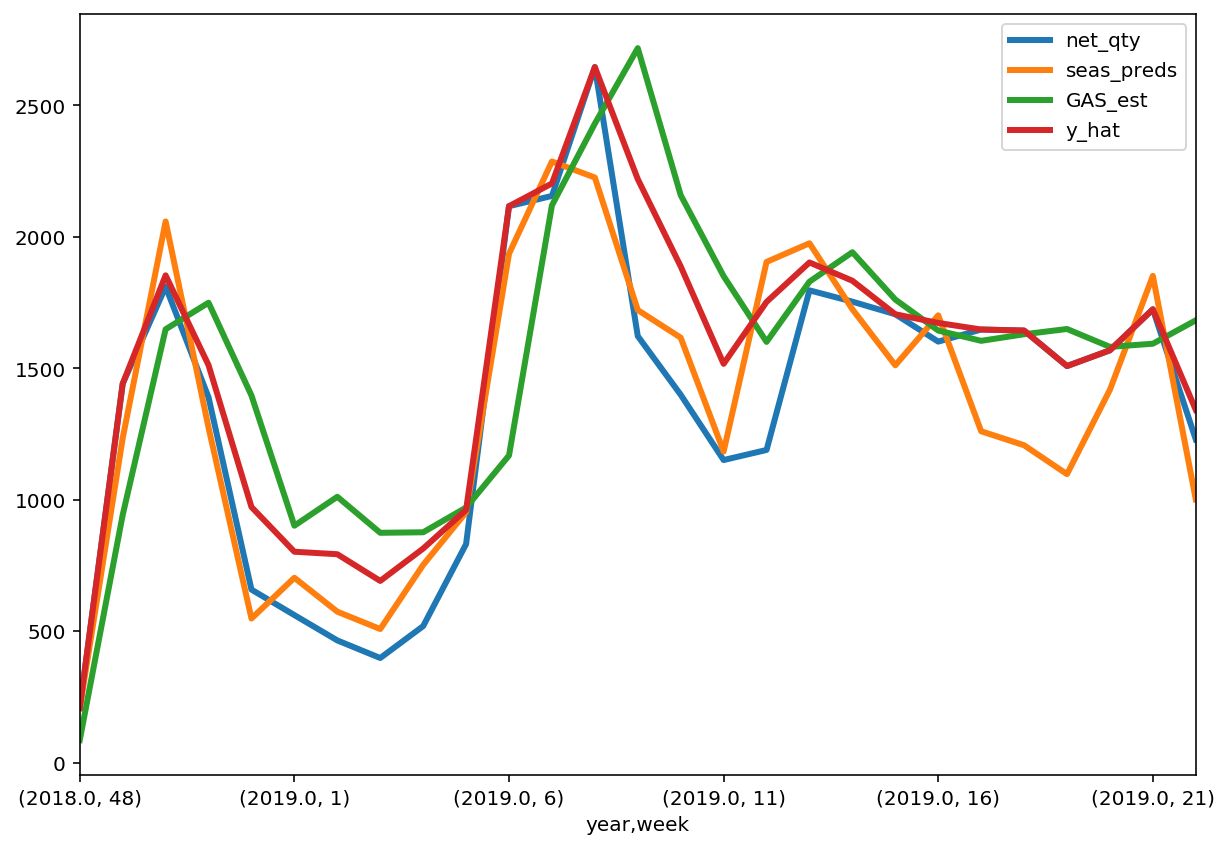

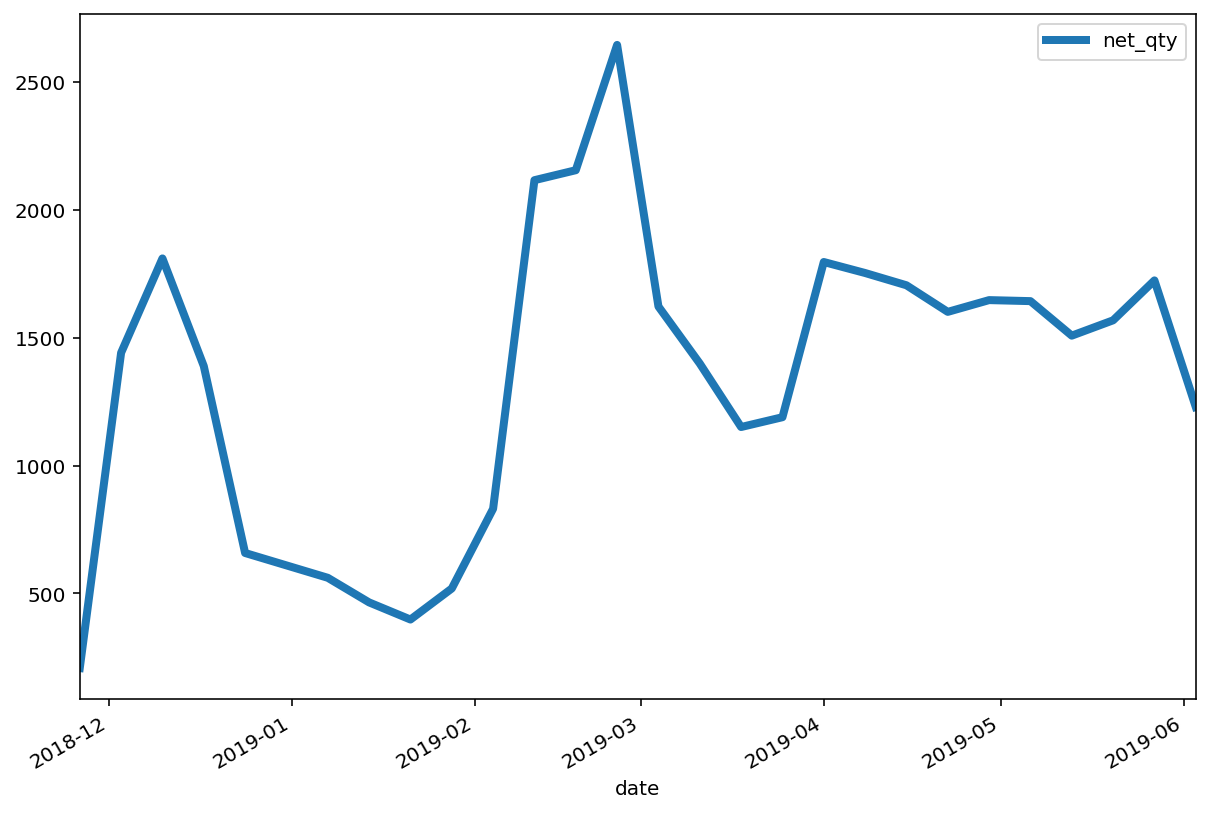

In [594]:
# Magnifying glass Plots -- 
aoi = 'G27706'
a = aoi

#dat0[dat0.article_number == aoi].sort_values(['country', 'year', 'week'])#.iloc[1,]


preds_season[preds_season.article_number == a]

dat_a = preds[preds.article_number == a]
dat_a.sort_values(['year', 'week']).set_index(['year', 'week']).drop('article_number', axis = 1).apply(np.sum)

dat_a[~dat_a.net_qty.isna()]

plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values(['year', 'week']).set_index(['year', 'week']).plot(linewidth = 3)

dat_a.sort_values(['year', 'week']).set_index(['year', 'week'])

# dat0[dat0.article_number == aoi].sort_values(['country', 'year', 'week'])#.iloc[1,]

# plot -- 
dat_aoi = dat0[dat0.article_number == aoi].copy()
dat_aoi = pd.merge(pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(), dat_aoi[['year', 'week']].drop_duplicates())
dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]
plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# Overbuy

In [223]:
# functions -- 

from functools import partial
from scipy import optimize
from scipy import integrate
import scipy.stats as stats

# Loss --- demand, buy, margin, cost
def L(d, b, margin, cost):
    if d > b:
        return (d - b)*margin
    elif d < b:
        return (b - d)*cost
    elif d == b:
        return 0
    else:
        print('Error')

# E[L | buy, article_mean, article_sd, article_margin, article_cost]
def EL(mu, sigma, margin, cost, b):
    I = lambda x: L(x, b, margin, cost) * stats.norm.pdf(x, mu, sigma) # I for integrand
    Exp_loss = integrate.quad(I, 0, mu + 3*sigma)/(1 - stats.norm.cdf(0, loc = mu, scale = sigma)) # Expected value of Loss function
    return round(Exp_loss[0], 2) 

def minimize_EL(mu, sigma, margin, cost):
    if pd.isna([margin, cost]).sum() > 0:
        print(mu, sigma, margin, cost)
        return 'Error'
    if(mu < 1000):
        return 1.2*mu 
    p = partial(EL, mu, sigma, margin, cost) # Make EL function of only one var: b_0
    buy_opt = optimize.minimize_scalar(p, bounds = (mu, mu + 2*sigma))
    return int(buy_opt['x']) # optimal buy quantity

In [294]:
# Load cost/margin data
cost_margin = dat0.copy()
# cost_margin = cost_margin[cost_margin.season.isin(['SS18', 'FW18', 'SS19', 'FW19'])]

cost_margin = cost_margin[cost_margin.article_number.isin(SS20.article_number)]

cost_margin = pd.DataFrame(cost_margin.groupby('article_number')['price', 'cost', 'margin'].mean().round(2)).dropna() # All but one NA is season_net_qty < 10


In [297]:
# Add cost and margin for optimal overbuy estimation                                                                           
preds_season = pd.merge(preds_season, cost_margin, how = 'left', left_on = 'article_number', right_index=True).round()

In [321]:
preds_season = preds_season[~((preds_season['eCom Market FC'] < 100) & (preds_season.y_hat < 100)) & (preds_season.y_hat > 20)].copy()


In [372]:
preds_season

,article_number,brand,model_no,description,type,BU,RMH,price,cost,margin,net_forecast,buy_recommendation,eCom_FC
0,011040,ADIDAS,10009,WORLD CUP,FOOTBALL SHOES (SOFT GROUND),BU FOOTBALL,FOOTBALL GENERIC,149.0,36.0,113.0,990.0,1188,186
1,015110,ADIDAS,10034,COPA MUNDIAL,FOOTBALL SHOES (FIRM GROUND),BU FOOTBALL,FOOTBALL GENERIC,184.0,32.0,151.0,5015.0,6461,873
2,019000,ADIDAS,10075,SAMBA,FOOTBALL SHOES (INDOOR),BU FOOTBALL,FOOTBALL GENERIC,69.0,16.0,53.0,11327.0,13380,1613
3,019228,ADIDAS,19031,MUNDIAL TEAM,FOOTBALL SHOES (TURF),BU FOOTBALL,FOOTBALL GENERIC,137.0,22.0,115.0,3529.0,4771,505
4,019310,ADIDAS,20053,Mundial Goal,FOOTBALL SHOES (INDOOR),BU FOOTBALL,FOOTBALL GENERIC,141.0,20.0,121.0,1887.0,2888,361
5,033200,ADIDAS,02636,KAISER 5 CUP,FOOTBALL SHOES (SOFT GROUND),BU FOOTBALL,FOOTBALL GENERIC,104.0,27.0,77.0,1124.0,1667,175
6,033201,ADIDAS,02637,KAISER 5 LIGA,FOOTBALL SHOES (FIRM GROUND),BU FOOTBALL,FOOTBALL GENERIC,100.0,27.0,74.0,2888.0,3589,429
7,033905,ADIDAS,93755,Fieldplayer,GLOVE (BALL GLOVE),BU FOOTBALL,FOOTBALL GENERIC,23.0,5.0,17.0,7625.0,9169,1424
8,218977,ADIDAS,U1227,3 STRIPE D 29.5,BALL (VULCANISED),BU BASKETBALL,BASKETBALL GENERIC,15.0,3.0,12.0,1785.0,2560,399
9,280647,ADIDAS,34725,ADILETTE,SLIDES,BU ORIGINALS FTW,ORIGINALS,34.0,6.0,28.0,103885.0,123604,24824


In [319]:
# Opt_Ovb = preds_season.apply(lambda row: minimize_EL(row['y_hat'], 550 + 0.2*row['y_hat'], row['margin'], row['cost']), axis=1)


501.0 650.2 nan nan
67.0 563.4 nan nan
34.0 556.8 nan nan
36.0 557.2 nan nan
140.0 578.0 nan nan
486.0 647.2 nan nan


In [322]:
preds_season['Opt_Ovb'] = Opt_Ovb


In [325]:
preds_season[preds_season.Opt_Ovb == 'Error']

,article_number,y_hat,eCom Market FC,price,cost,margin,Opt_Ovb
369,CL5087,501.0,200,NaN,NaN,NaN,Error
1413,FJ6181,67.0,727,NaN,NaN,NaN,Error
1455,FL4001,34.0,834,NaN,NaN,NaN,Error
1462,FL4209,36.0,1323,NaN,NaN,NaN,Error
1475,FL4626,140.0,956,NaN,NaN,NaN,Error
1602,Q08787,486.0,220,NaN,NaN,NaN,Error


In [ ]:

# --- Overbuy statistics ---
# preds_season['pct_overbuy'] = (preds_season.Opt_Ovb - preds_season.y_hat)/preds_season.y_hat*100
# b = np.array([0, 1000, 2000, 5000, 10000, 50000])
# preds_season['bins'] = pd.cut(preds_season.y_hat, bins = b)
# preds_season.groupby('bins')['pct_overbuy'].describe().round()


# Stealth carryovers

In [ ]:
carryovers.intersection(['EE6147', 'B22716', 'EE6145', 'EE6146'])

carryovers.intersection(['FW5947', 'FV5946', 'FV5943', 'FV5943'])



In [ ]:
# all -- 

stealth = pd.read_csv('data/stealth_carryovers_FW2020.csv', low_memory = False, error_bad_lines = False, sep = ";")

# stealth2 = pd.read_csv('data/stealth_carryovers_eu_RMA2.csv').rename(columns = {'article1': 'article', 'article2': 'stealth_article'})
# stealth3 = pd.concat([stealth, stealth2])

FW19_range = buyer_table.article_number.unique()
FW20_range = set(rma2_adi['Article Number']).union(set(rma2_rbk['Article Number']))

# New forecasts: IN FW20 --- NOT IN FW19
additions = stealth[(stealth.article.isin(FW20_range)) & (~(stealth.article.isin(carryovers)))] 

find_me = additions.stealth_article

dat_stealth = dat0[
    (dat0.article_number.isin(['BB9103', 'BB9104'])) &
    (dat0.season.isin(['FW18', 'FW17', 'FW16', 'FW15']))].copy()

dat_stealth = dat_stealth[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'buy_availability']].sort_values(['article_number', 'country', 'year', 'week'])

# GAS step

dat_GAS_stealth = dat_stealth.groupby(['article_number', 'country']).apply(GAS_est).reset_index()
dat_GAS_stealth = pd.DataFrame(dat_GAS_stealth.groupby(['article_number', 'year', 'week'])['GAS_est'].sum()).reset_index()

# SEASONALITY step
seasonality_dat_stealth = (dat0[dat0.article_number.isin(['BB9103', 'BB9104'])].
    copy()[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 
            'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 
            'age_group_desc', 'franchise', 'prod_grp_desc']].
    dropna().sort_values(['article_number', 'year', 'week'])
                  )

# -- Sum over UK/EU, ADD article reference data --
seasonality_dat_stealth = pd.merge(
    pd.DataFrame(seasonality_dat_stealth.groupby(['article_number', 'season', 'year', 'week'])['net_qty'].sum()).reset_index(), # sum over UK & EU
    seasonality_dat_stealth[['article_number', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() # add reference information
    ).dropna().sort_values(['article_number', 'year', 'week'])

seasonality_dat_stealth = seasonality_dat_stealth[seasonality_dat_stealth.season == 'FW18']

preds_stealth = seasonality_dat_stealth.groupby(['article_number']).apply(regress).reset_index()

# Merge back with reference data
preds_stealth = pd.merge(
    preds_stealth,
    seasonality_dat_stealth[seasonality_dat_stealth.season == 'FW18'],
    how = 'left').sort_values(['article_number', 'year', 'week'])[['article_number', 'year', 'week', 'net_qty', 'seas_preds']] # .fillna(method='ffill')


# Zero out negative preds
preds_stealth['seas_preds'] = np.where(preds_stealth.seas_preds > 0, preds_stealth.seas_preds, 0) 



# Combined observed weeks (partial season)  --- AND --- regression predicted (all) weeks
preds_stealth = pd.merge(
    preds_stealth,   # all weeks
    dat_GAS_stealth, # observed weeks
    how = 'left')



# weekly assignment of GAS, seasonality, or combination
preds_stealth['y_hat'] = np.where(np.isnan(preds_stealth.GAS_est), preds_stealth.seas_preds, (preds_stealth.GAS_est + preds_stealth.seas_preds)/2)



# Sum over season
preds_season_stealth = pd.DataFrame(preds_stealth.groupby('article_number')['y_hat'].apply(sum).round())



# Growth
preds_season_stealth['y_hat'] = preds_season_stealth.y_hat # * 1.1 # default growth rate

# Match stealth to its carryover
preds_season_stealth = pd.merge(
    preds_season_stealth,
    additions,
    how = 'left', left_index = True, right_on = 'stealth_article'
).drop('stealth_article', axis = 1).rename(columns = {'article': 'article_number'}).set_index('article_number')

# Combine DAA + eCom
preds_season_stealth = pd.merge(
    preds_season_stealth.reset_index(),  # DAA forecasts
    rma2,                                # eCom RMA2 forecast
    how = 'left', left_on='article_number', right_on='Article Number'
).drop('Article Number', axis = 1).round()

# add price/cost for optimal overbuy
preds_season_stealth = pd.merge(preds_season_stealth, cost_margin, how = 'left', left_on = 'article_number', right_index=True).round()



# see evaluation.ipynb for sd estimation 

opt_ovb_stealth = pd.DataFrame(preds_season_stealth.
                           apply(lambda row: minimize_EL(row['y_hat'], 550 + 0.2*row['y_hat'], row['margin'], row['cost']), axis=1)
                          )

opt_ovb_stealth = opt_ovb_stealth.rename(columns = {opt_ovb_stealth.columns[0]: 'Opt_Ovb'})

# Combine with data
preds_season_stealth = pd.merge(
    preds_season_stealth, # everything
    opt_ovb_stealth,      # optimal overbuy
    right_index= True, left_index= True
)

# IMPACT
# preds_season_stealth['impact'] = preds_season_stealth.apply(lambda row: np.abs(row['y_hat'] - row['WE eCom'])*(row['cost'] + row['margin']), axis = 1).round()                                                
# preds_season_stealth = preds_season_stealth.sort_values('impact', ascending = False).round()
             
# Reorder for concatenating
preds_season_stealth = preds_season_stealth[['article_number', 'y_hat', 'WE eCom', 'price', 'cost', 'margin', 'Opt_Ovb']]
                                            
                                            
                                            

In [ ]:
# Combine stealth with the rest

preds_season = pd.concat([preds_season, preds_season_stealth], sort=True)[['article_number', 'y_hat', 'WE eCom', 'price', 'cost', 'margin', 'Opt_Ovb']]


In [ ]:
preds_season.head()
preds_season.shape

preds.head()

# Saving Checkpoint

In [326]:
# preds_season.to_excel('data/SS20_forecasts.xlsx')

In [ ]:
# --- CLEARANCE-INCLUDED ---

# preds.to_excel('data/preds_all.xlsx')
# preds_season.to_excel('data/preds_season_all.xlsx')


# --- Clearance NOT included ---

# preds.to_excel('data/preds.xlsx')
preds.head()

# preds_season.to_excel('data/preds_season.xlsx')
preds_season.head()


In [ ]:
# --- READ IN non/all DATA --- 

preds_all = pd.read_excel('data/preds_all.xlsx').drop('Unnamed: 0', axis = 1)
preds_season_all = pd.read_excel('data/preds_season_all.xlsx').drop('Unnamed: 0', axis = 1)

preds = pd.read_excel('data/preds.xlsx').drop('Unnamed: 0', axis = 1)
preds_season = pd.read_excel('data/preds_season.xlsx').drop('Unnamed: 0', axis = 1)

# Columns (add, rename, AA), Rounding

In [327]:
preds_season.head()

,article_number,y_hat,eCom Market FC,price,cost,margin,Opt_Ovb
0,011040,990.0,186,149.0,36.0,113.0,1188
1,015110,5015.0,873,184.0,32.0,151.0,6461
2,019000,11327.0,1613,69.0,16.0,53.0,13380
3,019228,3529.0,505,137.0,22.0,115.0,4771
4,019310,1887.0,361,141.0,20.0,121.0,2888


In [331]:
preds_season['pct_difference'] = ((preds_season.y_hat - preds_season['eCom Market FC'])/preds_season['eCom Market FC'] * 100).round(2)


In [ ]:
# April Allen requested columns 

# aa_cols = pd.read_csv('data/columns_22october.csv', ...)
# aa_cols = pd.read_csv('data/columns_11November.csv', ...)

aa_cols = pd.read_csv('data/columns_21November.csv', low_memory = False, error_bad_lines = False, sep = ";")
aa_cols.at[0, 'FW19_total_market_FC'] = 400

# Add leading zero to short article numbers
for i in aa_cols.index:
    if len(aa_cols.iloc[i]['article_number']) == 5:
        aa_cols.at[i, 'article_number'] = '0' + aa_cols.iloc[i]['article_number']
        
aa_cols = aa_cols.drop_duplicates(subset = 'article_number') # One duplicate

preds_season = pd.merge(preds_season, aa_cols, how = 'left', left_on = 'article_number', right_on = 'article_number')

preds_season['FW19_total_ecom_SO'] = [np.float(str(x).replace('.', '')) for x in preds_season.FW19_total_ecom_SO] 

In [142]:
ref_dat0.columns

Index(['article_no', 'model_no', 'art_desc', 'brand_desc', 'sports_cat_desc',
       'bus_unit_desc', 'rmh_cat_desc', 'prod_grp_desc', 'prod_type_desc',
       'gender_desc', 'age_group_desc', 'franchise'],
      dtype='object')

In [333]:
preds_season = pd.merge(preds_season, ref_dat0[['article_no', 'model_no', 'art_desc', 'brand_desc',
       'bus_unit_desc', 'rmh_cat_desc', 'prod_grp_desc', 'prod_type_desc',
       'gender_desc', 'age_group_desc']], left_on='article_number', right_on='article_no').drop('article_no', axis = 1)


In [334]:
preds_season = preds_season.rename(columns = {'y_hat': 'net_forecast', 'Opt_Ovb': 'buy_recommendation', 'art_desc': 'description', 'eCom Market FC': 'eCom_FC', 
                                              'prod_type_desc': 'type', 'brand_desc': 'brand', 'bus_unit_desc': 'BU', 'rmh_cat_desc': 'RMH'})

In [338]:
preds_season = preds_season[['article_number',  'brand', 'model_no', 'description', 'type', 'BU', 'RMH', 
                             'price', 'cost', 'margin', 'net_forecast', 'buy_recommendation', 'eCom_FC']] # 'eCom_ILS1', 
                             #'FW19_total_market_FC', 'FW19_total_ecom_SO', 'FW19_total_ecom_RDP']] # space after RDP?

In [ ]:
# misc -- 

# preds_season.loc[:, 'impact'] = preds_season.apply(lambda row: np.abs(row['net_forecast'] - row['eCom_ILS1'])*(row['cost'] + row['margin']), axis = 1).round()                                                
             
# preds_season_all = pd.read_excel('data/preds_season_all.xlsx').drop('Unnamed: 0', axis = 1).rename(columns = {'y_hat': 'net_forecast_incl_clearance', 'Opt_Ovb': 'buy_rec_incl_clearance'})


# preds_season.shape

# preds_season_both = pd.merge(preds_season, preds_season_all[['article_number', 'net_forecast_incl_clearance', 'buy_rec_incl_clearance']], how = 'left')

# preds_season_both = preds_season_both[['article_number', 'brand', 'model_no', 'description', 'type', 'BU', 'RMH', 'price', 'cost', 'margin', 
#                                        'net_forecast', 'buy_recommendation', 'net_forecast_incl_clearance', 'buy_rec_incl_clearance', 'eCom_ILS1', # 'pct_difference',
#                                        'FW19_total_market_FC', 'FW19_total_ecom_SO', 'FW19_total_ecom_RDP']].set_index('article_number')

# preds_season_both['buy_rec_incl_clearance'] = np.where(preds_season_both['buy_rec_incl_clearance'] > preds_season_both['buy_recommendation'], preds_season_both['buy_rec_incl_clearance'], preds_season_both['buy_recommendation'])
# preds_season_both['net_forecast_incl_clearance'] = np.where(preds_season_both['net_forecast_incl_clearance'] > preds_season_both['net_forecast'], preds_season_both['net_forecast_incl_clearance'], preds_season_both['net_forecast'])

# # Convert to integers to remove '.0' endings
# for c in preds_season_both.columns:
#     if type(preds_season_both[c][1]) == np.float64:
#         preds_season_both.loc[:, c] = preds_season_both[c].fillna(0).replace(np.inf, 0).astype(int)


# preds_season_both = preds_season_both[~preds_season_both.index.isin(unreliable)]



# Load including-clearance forecasts

In [ ]:
# preds_season_both.to_excel('FW20_forecasts_incl_cl.xlsx')

In [ ]:
# preds_all = pd.read_excel('data/preds_all.xlsx').drop('Unnamed: 0', axis = 1)
# preds_season_all = pd.read_excel('data/preds_season_all.xlsx').drop('Unnamed: 0', axis = 1)

# preds = pd.read_excel('data/preds.xlsx').drop('Unnamed: 0', axis = 1)
# preds_season = pd.read_excel('data/preds_season.xlsx').drop('Unnamed: 0', axis = 1)

preds_season_both = pd.read_excel('FW20_forecasts_incl_cl.xlsx').drop('Unnamed: 0', axis = 1)

In [ ]:
preds_season_both = preds_season_both.rename(columns = {'eCom_ILS1': 'eCom_21Nov'}).set_index('article_number')

In [ ]:
preds_season_both.head()

In [ ]:
# preds_season_both['net_forecast_diff'] = preds_season_both['net_forecast_incl_clearance'] - preds_season_both['net_forecast']
# preds_season_both.sort_values('net_forecast_diff', ascending = False)


# Magnifying Glass

In [ ]:
# Unreliable forecasts

unreliable = list(['G26523', 'EJ9682', 'EE9391', 'EE8947', 'EE8943', 'BS0980', # initial delivery removal
                   'EE4727' # including-clearance stage removal
                  ]) 
                   # 'DV2810' # , 'DV0152', 'DV0169', 'DV0170', 'BD7611', 'ED8620', 'ED8712', 'G26487', 'EC6229', 'G26535',
    

In [379]:
# preds_season.loc[:, 'diff'] = preds_season['net_forecast'] - preds_season['eCom_FC']


In [384]:
preds_season.sort_values('diff', ascending = False)[['article_number', 'net_forecast', 'buy_recommendation', 'eCom_FC',
       'diff', 'brand', 'model_no', 'description', 'type', 'BU', 'RMH']].set_index('article_number')



,net_forecast,buy_recommendation,eCom_FC,diff,brand,model_no,description,type,BU,RMH
article_number,,,,,,,,,,
S21489,162789.0,188869,25756,137033.0,ADIDAS,GYB37,SOLID CREW SOCK,CREW SOCKS,BU ORIGINALS APP/ACC,ORIGINALS
M20325,158795.0,193731,25348,133447.0,ADIDAS,ION05,STAN SMITH,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS
S21490,103804.0,119421,18602,85202.0,ADIDAS,GYB37,SOLID CREW SOCK,CREW SOCKS,BU ORIGINALS APP/ACC,ORIGINALS
280647,103885.0,123604,24824,79061.0,ADIDAS,34725,ADILETTE,SLIDES,BU ORIGINALS FTW,ORIGINALS
M20324,99746.0,123745,21709,78037.0,ADIDAS,ION05,STAN SMITH,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS
BB5476,56778.0,68904,7209,49569.0,ADIDAS,IAZ12,GAZELLE,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS
BB5478,53765.0,65278,6715,47050.0,ADIDAS,IAZ12,GAZELLE,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS
S75104,47029.0,57343,5089,41940.0,ADIDAS,GWD59,STAN SMITH,SHOES - LOW (NON FOOTBALL),BU ORIGINALS FTW,ORIGINALS
288022,59167.0,71089,17959,41208.0,ADIDAS,34725,ADILETTE,SLIDES,BU ORIGINALS FTW,ORIGINALS


In [385]:
# EDA Plots - Article

aoi = 'S21489'
a = aoi

,article_number,net_forecast,buy_recommendation,eCom_FC,diff,brand,model_no,description,type,BU,RMH
1465,S21489,162789.0,188869,25756,137033.0,ADIDAS,GYB37,SOLID CREW SOCK,CREW SOCKS,BU ORIGINALS APP/ACC,ORIGINALS


net_qty      129777.0
corrected     85985.0
y_hat        147989.0
dtype: float64

,net_qty,corrected,y_hat
week,,,
1,509.0,824.0,824.0
1,499.0,824.0,824.0
1,715.0,824.0,824.0
2,540.0,858.0,858.0
2,270.0,858.0,858.0
2,728.0,858.0,858.0
3,595.0,773.0,773.0
3,258.0,773.0,773.0
3,730.0,773.0,773.0


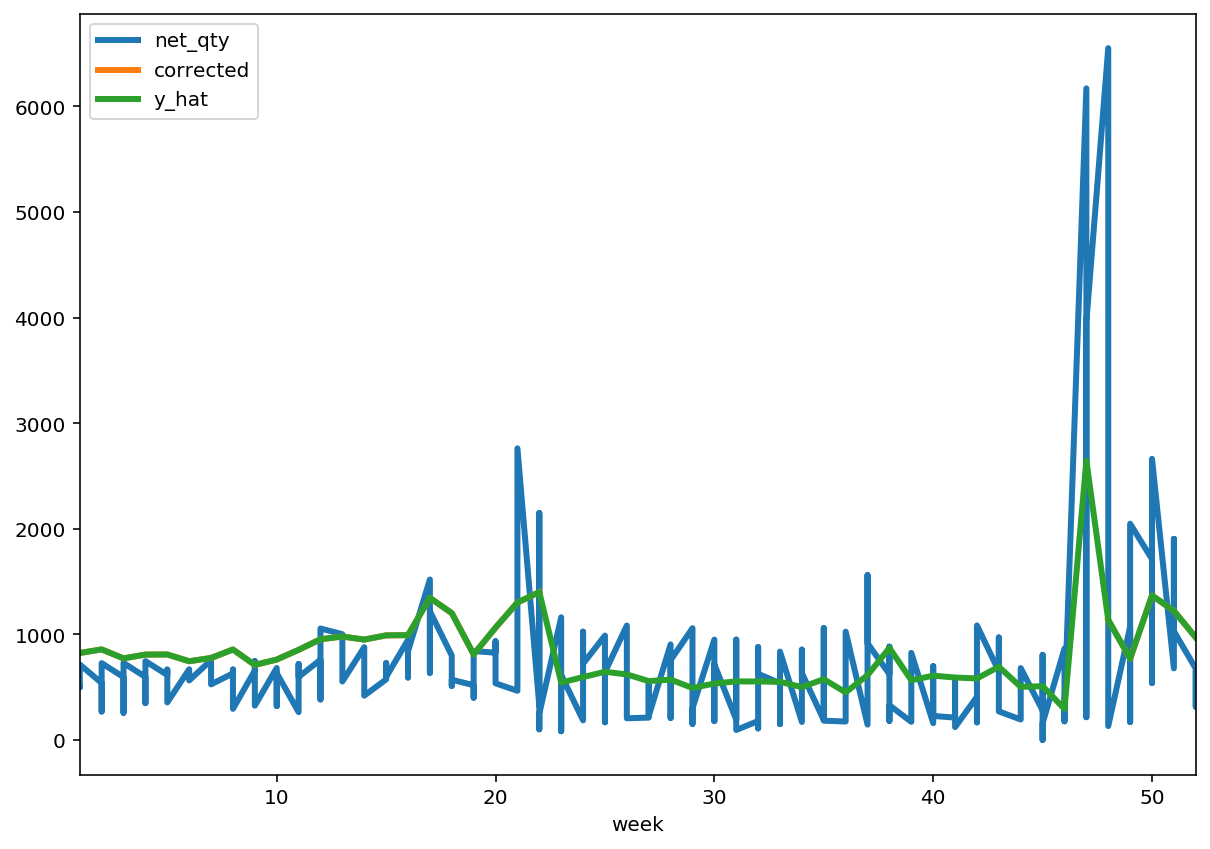

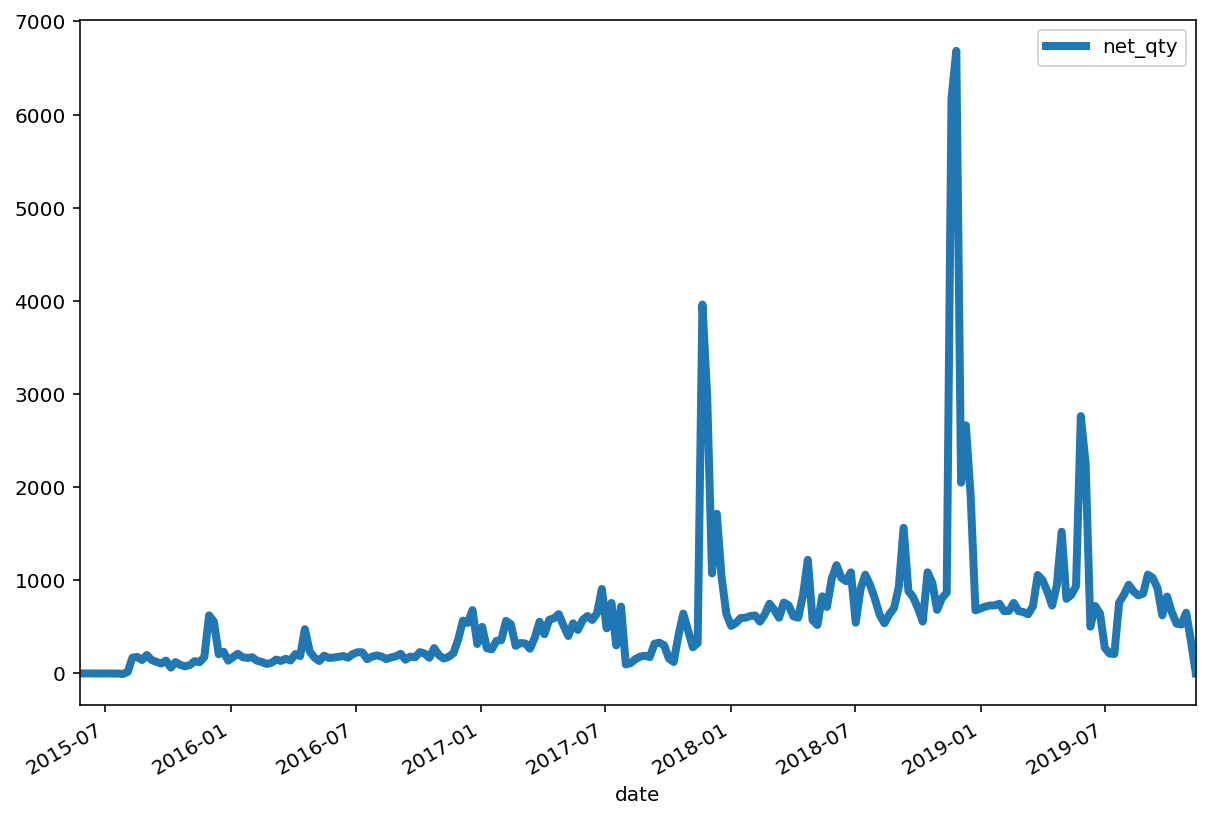

In [390]:
# EDA Plots -- 

preds_season[preds_season.article_number == a][['article_number', 'net_forecast', 'buy_recommendation', 
        'eCom_FC', 'diff', 'brand', 'model_no', 'description', 'type', 'BU', 'RMH']]

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'corrected', 'y_hat']].round()


plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)

dat_a.set_index('week').apply(np.sum).round()
dat_a.sort_values('week').set_index('week').round()

# dat0[dat0.article_number == aoi].sort_values(['country', 'year', 'week'])#.iloc[1,]

# plot -- 
dat_aoi = dat0[dat0.article_number == aoi].copy()
dat_aoi = pd.merge(pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(), dat_aoi[['year', 'week']].drop_duplicates())
dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]
plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

In [ ]:
# preds_season.shape
# preds_season = preds_season[~preds_season.article_number.isin(unreliable)]
# preds_season = preds_season[~preds_season.index.isin(unreliable)]

# preds_season.shape

In [ ]:
# ---- Comments ----

if preds_season.index.name != 'article_number':
    preds_season = preds_season.set_index('article_number')

preds_season['notes'] = '-'
preds_season.loc['EF0371', 'notes'] = 'Short FW19; our forecast assumes full FW20, with performance on par with observed FW19'
preds_season.loc['EE7570', 'notes'] = 'Short FW19, so not a lot of data to work with. Our forecast assumes full FW20, with performance on par with observed FW19'
preds_season.loc['F36641', 'notes'] = 'Forecast assumes FULL availability throughout FULL FW20'
preds_season.loc['EE6999', 'notes'] = 'late drop, our forecast assumes a full FW20'
preds_season.loc['CG6193', 'notes'] = 'Seasonality component of model is predicting strong end to FW19'
preds_season.loc['EE6464', 'notes'] = 'Late drop in FW19, but our forecast assumes full FW20.'
preds_season.loc['EE7773', 'notes'] = 'Shortened FW19, but forecast assumes full FW20.'
preds_season.loc['EE7775', 'notes'] = 'Short FW19, but our forecast assumes full FW20'

# preds_season.loc['DV0152', 'notes'] = 'All FW19 transactions are clearance.'
# preds_season.loc['DV0169', 'notes'] = 'All FW19 transactions are clearance.'
# preds_season.loc['DV2848', 'notes'] = 'Lots of clearance transactions (out of scope) pushed our numbers down'

# preds_season.loc['x', 'notes'] =
# preds_season.loc['x', 'notes'] =

In [ ]:
# preds_season.to_excel("FW20_forecasts.xlsx")


In [ ]:
if preds_season_both.index.name != 'article_number':
    preds_season_both = preds_season_both.set_index('article_number')

preds_season_both['notes'] = '-'
preds_season_both.loc['EF0371', 'notes'] = 'Short FW19; our forecast assumes full FW20, with performance on par with observed FW19'
preds_season_both.loc['EE7570', 'notes'] = 'Short FW19, so not a lot of data to work with. Our forecast assumes full FW20, with performance on par with observed FW19'
preds_season_both.loc['F36641', 'notes'] = 'Forecast assumes FULL availability throughout FULL FW20'
preds_season_both.loc['EE6999', 'notes'] = 'late drop, our forecast assumes a full FW20'
preds_season_both.loc['CG6193', 'notes'] = 'Seasonality component of model is predicting strong end to FW19'
preds_season_both.loc['EE6464', 'notes'] = 'Late drop in FW19, but our forecast assumes full FW20.'
preds_season_both.loc['EE7773', 'notes'] = 'Shortened FW19, but forecast assumes full FW20.'
preds_season_both.loc['EE7775', 'notes'] = 'Short FW19, but our forecast assumes full FW20'

In [ ]:
# preds_season_both.to_excel('FW20_forecasts_incl_cl.xlsx')

# Non-clearance vs. All

## EDA

In [ ]:
dat0 = pd.read_csv('data/ch4k.csv')
ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False, 
                       usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 
                                  'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc',
                                  'brand_desc', 'bus_unit_desc', 'rmh_cat_desc'])

In [ ]:
# All transactions
dat_all = dat0.copy()

In [ ]:
# Non-clearance transactions

# dat = dat0.copy()
# dat['clearance'] = dat.clearance.fillna(0) 
# dat['net_qty'] = (1 - dat.clearance)*dat.net_qty

In [ ]:
aoi = 'EE7570'

#dat_eda = dat[(dat.article_number.isin([aoi])) & (dat.season.isin(['FW19', 'FW18', 'FW17', 'FW16', 'FW15']))].copy()
dat_eda = dat_all[(dat_all.article_number.isin([aoi])) & (dat_all.season.isin(['FW19', 'FW18', 'FW17', 'FW16', 'FW15']))].copy()

dat_eda = dat_eda[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'buy_availability']].sort_values(['article_number', 'country', 'year', 'week'])

# GAS step

dat_GAS_eda = dat_eda.groupby(['article_number', 'country']).apply(GAS_est).reset_index()
dat_GAS_eda = pd.DataFrame(dat_GAS_eda.groupby(['article_number', 'year', 'week'])['GAS_est'].sum()).reset_index()

In [ ]:
both = pd.read_excel('data/both.xlsx')
# both['diff'] = both.apply(lambda row: row['net_forecast_y'] - row['net_forecast_x'], axis = 1)

both.sort_values('diff', ascending = True)

In [ ]:
# SEASONALITY step
# seasonality_dat_eda = (dat0.
seasonality_dat_eda = (dat_all[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 
                                'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 
                                'age_group_desc', 'franchise', 'prod_grp_desc']].
                       dropna().
                       sort_values(['article_number', 'year', 'week']).
                       copy()
                  )

In [ ]:
# -- Sum over UK/EU, ADD article reference data --
seasonality_dat_eda = pd.merge(
    pd.DataFrame(seasonality_dat_eda.groupby(['article_number', 'season', 'year', 'week'])['net_qty'].sum()).reset_index(), # sum over UK & EU
    seasonality_dat_eda[['article_number', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() # add reference information
    ).dropna().sort_values(['article_number', 'year', 'week'])



In [ ]:
seasonality_dat_eda.shape

In [ ]:
# -- Reliable, mirror seasons --
seasonality_dat_eda = seasonality_dat_eda[seasonality_dat_eda.season.isin(['FW15', 'FW16', 'FW17', 'FW18', 'FW19'])]

# ---- Calculate cat-level weekly means across *ALL SEASONS* ---- 

seasonality_sport   = pd.DataFrame(seasonality_dat_eda.groupby(['sports_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})
seasonality_rmh     = pd.DataFrame(seasonality_dat_eda.groupby(['rmh_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean'})
seasonality_gndr    = pd.DataFrame(seasonality_dat_eda.groupby(['gender_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean'})
seasonality_agegrp  = pd.DataFrame(seasonality_dat_eda.groupby(['age_group_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean'})
seasonality_frnchse = pd.DataFrame(seasonality_dat_eda.groupby(['franchise', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean'})
seasonality_prdgrp  = pd.DataFrame(seasonality_dat_eda.groupby(['prod_grp_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean'})

seasonality_dfs = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]


In [ ]:
seasonality_dat_eda = seasonality_dat_eda[(seasonality_dat_eda.season == 'FW19') & (seasonality_dat_eda.article_number == aoi)]


In [ ]:


preds_eda = seasonality_dat_eda.groupby(['article_number']).apply(regress).reset_index()

In [ ]:
# Merge back with reference data
preds_eda = pd.merge(
    preds_eda,
    seasonality_dat_eda,
    how = 'left').sort_values(['article_number', 'week'])[['article_number', 'year', 'week', 'net_qty', 'seas_preds']] # .fillna(method='ffill')

In [ ]:
# Zero out negative preds
preds_eda['seas_preds'] = np.where(preds_eda.seas_preds > 0, preds_eda.seas_preds, 0) 

In [ ]:
# Combined observed weeks (partial season)  --- AND --- regression predicted (all) weeks
preds_eda = pd.merge(
    preds_eda,   # all weeks
    dat_GAS_eda, # observed weeks
    how = 'left')

In [ ]:
# weekly assignment of GAS, seasonality, or combination
preds_eda['y_hat'] = np.where(np.isnan(preds_eda.GAS_est), preds_eda.seas_preds, (preds_eda.GAS_est + preds_eda.seas_preds)/2).round()

# Sum over season
# preds_season_eda = pd.DataFrame(preds_eda.groupby('article_number')['y_hat'].apply(sum).round())

# Growth
# preds_season_eda['y_hat'] = preds_season_eda.y_hat # * 1.1 # default growth rate
                                           
                                            
                                            

In [ ]:
preds_eda.y_hat.sum()

In [ ]:
preds_eda

In [ ]:
# EE7570_0 = preds_eda.copy()
EE7570_0.head()

In [ ]:
# EE7570_1 = preds_eda.copy()

In [ ]:
EE7570_0.head()
EE7570_1.head()

In [ ]:
both[both.article_number == aoi].head()

In [ ]:
both.shape
# both[['net_forecast_x', 'net_forecast_y', 'diff']]

both['diff'].describe().round()
both['diff'].hist(bins = [-2500, 0, 1000, 12000])
# without clearance ---- with clearance

In [ ]:
# both.to_excel('data/both.xlsx')

## Comparison

In [ ]:
preds_season = pd.read_excel('data/preds_season.xlsx').drop('Unnamed: 0', axis = 1)
preds_season_all = pd.read_excel('data/preds_season_all.xlsx').drop('Unnamed: 0', axis = 1)

In [ ]:
preds_season.head()
preds_season_all.head()

In [ ]:
preds_season.columns

In [ ]:
both = pd.merge(
    preds_season[['article_number', 'y_hat', 'Opt_Ovb']], 
    preds_season_all[['article_number', 'y_hat', 'Opt_Ovb', 'WE eCom']],
    left_on='article_number', right_on='article_number'
).rename(columns = {
    'y_hat_x': 'net_forecast', 
    'Opt_Ovb_x': 'buy_recommendation',
    'y_hat_y': 'net_forecast_w_clearance',
    'Opt_Ovb_y': 'buy_recommendation_w_clearance'
})


both['buy_recommendation_w_clearance'] = np.where(both['buy_recommendation_w_clearance'] > both['buy_recommendation'], both['buy_recommendation_w_clearance'], both['buy_recommendation'])
both['net_forecast_w_clearance'] = np.where(both['net_forecast_w_clearance'] > both['net_forecast'], both['net_forecast_w_clearance'], both['net_forecast'])

both['net_forecast_diff'] = both['net_forecast_w_clearance'] - both['net_forecast']
both['buy_rec_diff'] = both['buy_recommendation_w_clearance'] - both['buy_recommendation']

both

In [ ]:
both.net_forecast_diff.describe().round()

both.buy_rec_diff.describe().round()

In [ ]:
both.net_forecast_diff.describe().round()

both.buy_rec_diff.describe().round()

# Appendix

In [ ]:
# # adidas v rbk
# from pandas import DataFrame, Series
# fw20['brand'].value_counts()

# # Carryover coverage
# fw20['rev'] = fw20.price * fw20.eCom_RMA1
# fw20.groupby('brand')['rev'].sum()

In [ ]:
# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
aoi = 'DP2405'
a = aoi

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
        
plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()

dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index == a]

dat_aoi = dat0[dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

In [ ]:
### ================= ARIMAX =================

pd.DataFrame(preds)

# Subset for troubleshooting
a = np.random.choice(seasonality_dat.article_number.unique(), size = 1, replace = False)
dat_a = seasonality_dat[seasonality_dat.article_number.isin(a)]


y = dat_a[['net_qty', 'week']].set_index('week')

x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == dat_a.sports_cat_desc.unique()[0]].set_index('week')
x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == dat_a.rmh_cat_desc.unique()[0]].set_index('week')
x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == dat_a.gender_desc.unique()[0]].set_index('week')
x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == dat_a.age_group_desc.unique()[0]].set_index('week')
x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == dat_a.franchise.unique()[0]].set_index('week')
x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == dat_a.prod_grp_desc.unique()[0]].set_index('week')

yX = (pd.merge(y, x_sport, left_index=True, right_index=True, how = 'outer').
      merge(x_rmh, left_index=True, right_index=True, how = 'outer').
      merge(x_gndr, left_index=True, right_index=True, how = 'outer').
      merge(x_agegrp, left_index=True, right_index=True, how = 'outer').
      merge(x_frnchse, left_index=True, right_index=True, how = 'outer').
      merge(x_prdgrp, left_index=True, right_index=True, how = 'outer').
      drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
           'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

yw = dat[dat.season == 'SS19'][['year', 'week']].drop_duplicates().sort_values(['year', 'week'])

yw.loc[:,'YEAR'] = [str(x)[:-2] for x in yw.year]
yw.loc[:,'WEEK'] = [str(x)[:-2] for x in yw.week]

yw.loc[:,'date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(yw.YEAR, yw.WEEK)]

yX = (pd.merge(yX, yw[['week', 'date']], left_index=True, right_on = 'week').
      drop('week', axis = 1).
      sort_values('date').
      set_index('date'))


reg = pd.merge(
    regress(dat_a),
    yw,
    left_index=True, right_on = 'week',
).set_index('date')

reg

# yX.index

# r = pd.date_range(start=yX.index.min(), end=yX.index.max(), freq = 'W')
# r

# yX #.reindex(r) #.fillna(0.0) # .rename_axis('dt').reset_index()

arimax = sm.tsa.statespace.SARIMAX(yX.net_qty,
                                   order = (1,0,1),
                                   seasonal_order = (0,0,0,0),
                                   exog = yX.drop('net_qty', axis = 1),
                                   enforce_stationarity=False, 
                                   enforce_invertibility=False,
                                   missing = 'drop').fit()

# arimax.summary()
preds = arimax.predict()
yX = pd.merge(
    yX, 
    pd.DataFrame(preds), right_index=True, left_index=True,
)

yX.columns
yX.iloc[:,7]

numerator = ((yX.net_qty - preds) ** 2).sum()
denominator = ((yX.net_qty - np.mean(yX.net_qty)) ** 2).sum()
1 - numerator/denominator



p = pd.DataFrame(index = yX.index)
p['net_qty'] = yX.net_qty
p['preds'] = arimax.predict()
p['original'] = yX.iloc[:,7]
p.plot()

### ================= End ARIMAXperiment =================

In [ ]:
# -- NA check --
# seasonality_dat[pd.isnull(seasonality_dat).any(axis=1)]

In [ ]:
# EDA Plots

preds_season = preds_season.reset_index()

# ---- Plot -----
# a = np.random.choice(preds.article_number.unique(), size = 1, replace = False)[0]
aoi = 'DV1549'
a = aoi

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'seas_preds']]
        
plt.rcParams["figure.figsize"] = [10,7]
dat_a.sort_values('week').set_index('week').plot(linewidth = 3)
dat_a.sort_values('week').set_index('week').round()

dat_a[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index == a]

dat_aoi = dat0[dat0.article_number == aoi].copy()

dat_aoi = pd.merge(
    pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aoi[['year', 'week']].drop_duplicates()
)

dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aoi[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

# dat_aoi

In [ ]:

# WE_eCom['WE eCom'] = [int(x.replace(",", "")) for x in WE_eCom['WE eCom']]


In [ ]:
# # DAVID code

# # Function Definitions

# class parameters():
#     def __init__(self, param_array):
#         self.alpha = param_array[0]
#         self.beta = param_array[1]
#         self.omega = param_array[2] / (1-self.beta) # one way to choose that is omega/(1-beta) = uncoMnditional mean
#         self.sigma = param_array[3]
#         self.f0 = param_array[4] # one way to choose is unconditional mean

# def loglik(x, y, f, sigma):
#     ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2
#     return ll

# def score_compute(x, y, f, sigma):
#     return (y - x*f)/sigma

# def score_compute_2(x, y, f, sigma=None):
#     return(y - x*f) # ** The 'type = 2' modification **

# def filterGAS(p, x, y, score_fun):
#     score0 = score_fun(x[0,:], y[0,:],p.f0, p.sigma)
#     f = np.zeros((len(y),1))
#     f[0,:] = p.f0
#     for t in range(1,len(y)):
#         scoret = score_fun(x[t-1,:], y[t-1,:], f[t-1,:], p.sigma)
#         f[t,:] = p.omega + p.alpha*scoret + p.beta*f[t-1,:]
#     return f


# def loglikest(params, x, y, score_fun):
#     p = parameters(params)
#     f = filterGAS(p, x, y, score_fun)
#     ll = np.zeros((len(y), 1))
#     m = len(y)
#     for t in range(0, len(y)):
#         ll[t,:] = loglik(x[t,:], y[t,:], f[t,:], p.sigma)
#     loglik_res = -(np.sum(ll))/m
#     return loglik_res


# def GAS_optimize(x, y, score_fun, marker_str):
#     return scipy.optimize.minimize(
#        loglikest,                              # function to minimize (log likelihood y|x,theta)
#        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
#        args=(x, y, score_fun),
#        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12}, # TODO pass as parameter or create config file
#        method='L-BFGS-B',
#        bounds=((0,  None),             # alpha
#                (-1, 1),                # beta
#                (0.001, np.mean(y)*2),  # omega
#                (0.001, None),          # sigma
#                (0.001, np.mean(y)*2)   # f
#               )
#        )



# def GAS_est(df):
#     """ <High level description of function>
#     Parameters
#     ----------
#     df : pandas DataFrame
#        <Description>
#     Returns
#     -------
#     ret: pandas DataFrame
#        <Description>
#     Raises
#     ------
#     (List and description of specific errors generated and thrown based on intenal function requirements)
#     OtherError when an other error
#     """
#     y = df.net_qty.values.reshape(-1,1)          # observed demand (response)
#     x = df.buy_availability.values.reshape(-1,1)   # buy_availability (explanatory)
    
#     ret = pd.DataFrame()
#     ret[['year','week']] = df[['year','week']]
    
#     score_fun = score_compute
#     marker_str = 'One'
    
#     opt_result = GAS_optimize(x, y, score_fun, marker_str)
    
#     if opt_result.success == False:
#         score_fun= score_compute_2
#         marker_str = 'Two'
#         opt_result = GAS_optimize(x, y, score_fun, marker_str)
        
#     x1par = parameters(opt_result.x)
#     GAS = filterGAS(x1par, x, y, score_fun)
    
#     ret['GAS_est'] = GAS
#     ret['Convergence'] = [opt_result.success] * len(y)
#     ret['Convg type'] = [marker_str] * len(y)
    
#     return ret

In [ ]:
# April articles

aas = ['DV1549', 'EE1152', 'DV1508', 'ED6024', 'CY4574', 'ED9384', 'BK7345', 'DV2400', 'DH5798']

# aoi = 'DV1549'
# a = aoi

preds_aa = (preds[preds.article_number.isin(aas)][['article_number', 'week', 'net_qty', 'GAS_est', 'seas_preds', 'y_hat']].
            sort_values(['article_number', 'week']).
            set_index('week')).round()
        

preds_aa[preds_aa.article_number == 'DV1549']

pred_aggs_aa = preds_aa.groupby('article_number')[['net_qty', 'GAS_est', 'seas_preds', 'y_hat']].apply(sum).round()



for c in pred_aggs_aa.columns:
    if type(pred_aggs_aa[c][1]) == np.float64:
        pred_aggs_aa[c] = pred_aggs_aa[c].fillna(0).astype(int)

pred_aggs_aa[~np.isnan(pred_aggs_aa.GAS_est)].loc[aas[i-1], 'y_hat'].sum()





fig = plt.figure(figsize=(25,32)); # width, height
fig.subplots_adjust(hspace=0.5, wspace=0.2); # vertical spacing, horizontal spacing
for i in range(1, 10):
    ax = fig.add_subplot(5, 2, i, )
    preds_ax = preds_aa[preds_aa.article_number == aas[i-1]]
    ax.plot(preds_ax.index, preds_ax['net_qty'], linewidth=4.5, label = 'Observed net_qty')
    ax.plot(preds_ax.index, preds_ax['y_hat'], linewidth=4.5, label = 'Model net_qty estimate')
    ax.set_title('Article: ' + aas[i-1] + 
                 ' \n net_qty STD: ' + str(pred_aggs_aa.loc[aas[i-1], 'net_qty']) + 
                 ' \n Full availability estimate STD: ' + str(preds_aa[(~np.isnan(preds_aa.GAS_est)) & (preds_aa.article_number == aas[i-1])].y_hat.sum().astype(int)) +
                 ' \n FW19 full season estimate: ' + str(pred_aggs_aa.loc[aas[i-1], 'y_hat']), 
                 fontsize=16)
    ax.legend()

fig.savefig('aa_fig.png')    

pass;



preds_aa[['GAS_est', 'net_qty', 'seas_preds']].apply(np.sum).round()

preds_season.reset_index()[preds_season.index.isin(aas)]

dat_aa = dat0[dat0.article_number.isin(aas)].copy()

dat_aa = pd.merge(
    pd.DataFrame(dat_aa.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),
    dat_aa[['year', 'week']].drop_duplicates()
)

dat_aa.year = [str(x) for x in dat_aa.year]
dat_aa.week = [str(x) for x in dat_aa.week]
dat_aa['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aa.year, dat_aa.week)]

plt.rcParams["figure.figsize"] = [10,7]
dat_aa[['date', 'net_qty']].set_index('date').plot(linewidth = 4)

In [ ]:
# ---------------- Product Lifecycle EDA -------------------

dat_lifespan = dat0.copy()

# Just article & season
dat_lifespan = dat_lifespan[['article_number', 'season']].drop_duplicates()

# Lifespan
dat_lifespan = pd.DataFrame(dat_lifespan.article_number.value_counts()).reset_index().rename(columns = {'index': 'article', 'article_number': 'lifespan'})

# net_qty per season
dat_lifespan2 = pd.DataFrame(dat0.groupby(['article_number', 'season'])['net_qty'].apply(sum)).reset_index()

# Combine
dat_lifespan = pd.merge(
    dat_lifespan2,
    dat_lifespan,
    how = 'left', left_on= 'article_number', right_on = 'article'
).drop('article', axis = 1)

# --- For sorting ---
key = {'SS14': 1, 'FW14': 2, 'SS15': 3, 'FW15': 4, 
       'SS16': 5, 'FW16': 6, 'SS17': 7, 'FW17': 8, 
       'SS18': 9, 'FW18': 10, 'SS19': 11, 'FW19': 12}
dat_lifespan['order_key'] = [key[s] for s in dat_lifespan.season]

dat_lifespan = dat_lifespan.sort_values(['article_number', 'order_key'])

dat_lifespan.drop

def lifecycle_season_assign(df):
    df = df.sort_values('order_key')

    ret = pd.DataFrame()
    ret['season'] = df.season
    ret['lifecycle_season'] = list(range(1, df.shape[0] + 1))

    return ret

lifecycle = dat_lifespan.groupby('article_number').apply(lifecycle_season_assign).reset_index().drop('level_1', axis = 1)

dat_lifecycle = pd.merge(
    dat_lifespan,
    lifecycle
)


dat_lifecycle

dat_lifecycle_medians = pd.DataFrame(dat_lifecycle.groupby(['lifespan', 'lifecycle_season'])['net_qty'].mean()).reset_index()

dat_lifecycle_medians = dat_lifecycle_medians[~dat_lifecycle_medians.lifespan.isin([1, 12])]

dat_lifecycle_medians

t = dat_lifecycle_medians.copy()

plt.figure(figsize=(16, 8))
sns.lineplot(x = t.lifecycle_season, y = t.net_qty, hue= t.lifespan, palette="tab10", linewidth=4).set_title('Means by Age, for Life-length Groups')

# set_index(['lifespan', 'lifecycle_season'])



sns.palplot(sns.color_palette())


# Tweaks, Rules

# preds['corrected_net_qty'] = (preds.GAS_est + preds.seas_preds)/2

# preds['corrected_net_qty'] = np.where(preds.corrected_net_qty < preds.net_qty, preds.net_qty, preds.corrected_net_qty)

# preds['y_hat'] = np.where(preds.y_hat < preds.net_qty, preds.net_qty, preds.y_hat)


In [ ]:
# preds_season.loc['G26535', 'notes'] = 'We have very few observed weeks for this article, due to late season launch; so at this stage the forecast for this article is unreliable.'
# preds_season.loc['EC6229', 'notes'] = 'We have very few observed weeks for this article, due to late season launch; so at this stage the forecast for this article is unreliable.'
# preds_season.loc['G26487', 'notes'] = 'We have very few observed weeks for this article, due to late season launch; so at this stage the forecast for this article is unreliable.'
# preds_season.loc['G26523', 'notes'] = 'We have very few observed weeks for this article, due to late season launch; so at this stage the forecast for this article is unreliable.'
# preds_season.loc['ED8712', 'notes'] = 'We have very few observed weeks for this article; so at this stage the forecast for this article is unreliable.'

# preds_season.loc['ED8620', 'notes'] = 'We have very few observed weeks for this article; so at this stage the forecast for this article is unreliable.'
# preds_season.loc['EJ9682', 'notes'] = 'With less than 10 weeks of observed net_qty for this article, one of which was quite large, the model is misbehaving and making pathological inferences --- this forecast is not reliable.'
# preds_season.loc['BD7611', 'notes'] = 'We have almost no non-clearance data on this article, and our (nonsensical?) forecast reflects this; actual net_qty of ~700 is same order of magnitude as eCom forecast -- which is good.'
# preds_season.loc['DV0170', 'notes'] = 'We have almost no non-clearance data on this article, and our (nonsensical?) forecast reflects this; actual net_qty of ~700 is same order of magnitude as eCom forecast -- which is good.'
# preds_season.loc['EE9391', 'notes'] = 'Only a handful of observed FW19 weeks; not a realistic/useful forecast.'

# preds_season.loc['EE8947', 'notes'] = 'Essentially no FW19 to work with, so our forecast is unrealistic; but better SS19, so your forecast seems reasonable.'

In [ ]:
# ----- For demo ------

fcsts = preds_season.copy()

# fcsts = pd.read_excel('data/FW20_forecasts.xlsx') # adidas RMA2 -- 21 October


fcsts.loc[:, 'impact'] = fcsts.apply(lambda row: np.where(row['buy_recommendation'] > row['eCom_ILS1'], 
                                                         (row['buy_recommendation'] - row['eCom_ILS1']) * row['margin'], 
                                                         (row['eCom_ILS1'] - row['buy_recommendation']) * row['cost']), axis = 1)

fcsts = fcsts.sort_values('impact', ascending = False).round()

fcsts = fcsts[['net_forecast', 'buy_recommendation', 'eCom_ILS1', 'impact', 'brand', 'description', 'type', 'BU', 'RMH', 'price', 'cost', 'margin',  'FW19_total_market_FC', 'notes']]


fcsts.head()

preds[preds.article_number == 'CG6708'].head()
dat0[dat0.article_number == 'CG6708'].head()

# EDA Plots

# ---- Plot -----
aoi = 'F34314'
a = aoi

# -------

dat_a = preds[preds.article_number == a][['week', 'net_qty', 'GAS_est', 'y_hat']]
dat_a['year'] = '2019'
dat_a.week = [str(x) for x in dat_a.week]
dat_a['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_a.year, dat_a.week)]

# -------

print('This season:')
print(dat_a[['net_qty', 'GAS_est', 'y_hat']].apply(np.sum).round())

dat_aoi = dat0[dat0.article_number == aoi].copy()

dat_aoi = pd.merge(pd.DataFrame(dat_aoi.groupby(['year', 'week'])['net_qty'].sum()).reset_index(),dat_aoi[['year', 'week']].drop_duplicates())
dat_aoi.year = [str(x) for x in dat_aoi.year]
dat_aoi.week = [str(x) for x in dat_aoi.week]
dat_aoi['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat_aoi.year, dat_aoi.week)]

# --------

full = pd.merge(dat_a, dat_aoi, how = 'outer').sort_values('date').set_index('date')

full = full[~((full.index > dt.datetime(2019, 5, 27))  & full.y_hat.isna())]
# full = full.drop_duplicates(subset = ['week'], keep = 'last')

full = full.rename(columns = {'y_hat': 'model net_qty'})

# --------

full.loc[dt.datetime(2019, 11, 4), 'net_qty'] = np.nan # manually change entry

full # ************

# ----
plt.rcParams["figure.figsize"] = [20,8]
full.drop('GAS_est', axis = 1).plot(linewidth = 3)
plt.ylabel('net_qty')
plt.title('Article net_qty: ' + aoi)

# -------

fcsts[fcsts.index == aoi]



In [ ]:
# dat_GAS_a = np.random.choice(dat_GAS.article_number.unique(), size = 100, replace = False)
# dat_GAS = dat_GAS[dat_GAS.article_number.isin(dat_GAS_a)]